# Plot uni-mutational fractions

Draws histograms of $\dfrac{N_2}{N_2 + N_3 + N_4}$ over all nth-CP positions in each sequence.

Supports first filtering to "mutated" positions.

In [1]:
%run "ComputeUniMutationalFractions.ipynb"

In [11]:
from collections import defaultdict
from parse_sco import parse_sco

def is_position_mutated(seq, pos, p):
    # based on GeneUtils' get_val() func
    if p is None:
        return True
    else:
        return pileup.naively_call_mutation(seq2pos2pileup, seq, pos, p)

def plot_unimut_frac_hists(p=None, figfilename=None):
    fig, axes = pyplot.subplots(3, 4, sharey="row")

    for figrow, seq in enumerate(SEQS):
        df = parse_sco("../seqs/genes/{}.sco".format(seq))
        
        # used to populate the text in the uni-mutational fraction section
        num_mutated_positions = defaultdict(int)
        
        # Go through each gene in this sequence. Find the CPs (and non-coding positions).
        # Record each position's "f" value, if present. Plot
        # a histogram of these f-values. (CP 4 is shorthand for "non-coding".)
        num2fvals = {1: [], 2: [], 3: [], 4: []}
        bases_in_genes = set()
        for gene in df.itertuples():
            i = 1
            pos_interval = get_pos_interval_from_gene(gene)
            bases_in_genes |= set(pos_interval)
            for pos in pos_interval:
                if is_position_mutated(seq, pos, p):
                    num_mutated_positions[i] += 1
                    f = seq2pos2f[seq][pos]
                    # Could also use this if statement to filter out certain f-values, e.g. < 1
                    if f is not None:
                        num2fvals[i].append(f)
                if i == 1:
                    i = 2
                elif i == 2:
                    i = 3
                elif i == 3:
                    i = 1
                else:
                    raise ValueError("Codon position modulo calculation is broken :|")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")

        bases_not_in_genes = set(range(1, seq2len[seq] + 1)) - bases_in_genes
        for pos in bases_not_in_genes:
            if is_position_mutated(seq, pos, p):
                num_mutated_positions["NC"] += 1
                f = seq2pos2f[seq][pos]
                if f is not None:
                    num2fvals[4].append(f)

        print("{}: Number of p-mutations using p = {}: {}".format(
            seq2name[seq], p, num_mutated_positions
        ))
        for figcol, cp in enumerate([1, 2, 3, 4]):
            print("{}, CP {}: mean (valid) f-value = {}, num valid f-values = {:,}".format(
                seq2name[seq], cp, mean(num2fvals[cp]), len(num2fvals[cp])
            ))
            ax = axes[figrow, figcol]
            ax.hist(num2fvals[cp], bins=20, color=cp2color[cp], edgecolor=BORDERCOLOR)
            if cp != 4:
                ax.set_title("{}: CP {} Positions".format(seq2name[seq], cp))
            else:
                ax.set_title("{}: Non-Coding Positions".format(seq2name[seq]))
                
            # We don't set the xlim to (0, 1) because doing that kinda cuts off the right border on the
            # bars which looks gross
            ax.set_xlim(0)
            ax.set_xlabel(r"Uni-mutational fraction")
            ax.set_ylabel("Frequency")
            use_thousands_sep(ax.get_yaxis())
            # This is a hack to make all CP plots in a row have the same y-axis. Ideally this'd be automatic
            # but uhhhh elbow grease is easier lol
    #         if seq2name[seq] == "CAMP":
    #             pyplot.ylim(0, 28000)
    #         elif seq2name[seq] == "BUT":
    #             pyplot.ylim(0, 18000)
    #         else:
    #             pyplot.ylim(0, 35000)
    #         pyplot.show()

    if p is None:
        suptitle = "Uni-mutational fractions (all valid values)"
    else:
        suptitle = f"Uni-mutational fractions (just $p$-mutations for $p$ = {p * 100}%)"
    fig.suptitle(
        suptitle,
        fontsize="26",
        y=0.93
    )
    fig.set_size_inches(25, 20)
    if figfilename is not None:
        fig.savefig("figs/{}".format(figfilename), bbox_inches="tight")

## Draw plots of the uni-mutational fraction, subset to just $p$-mutations ($p$ = 0.5%)

CAMP: Number of p-mutations using p = 0.005: defaultdict(<class 'int'>, {1: 52, 3: 113, 2: 54, 'NC': 64})
CAMP, CP 1: mean (valid) f-value = 0.962358302133307, num valid f-values = 52
CAMP, CP 2: mean (valid) f-value = 0.9702482450464484, num valid f-values = 54
CAMP, CP 3: mean (valid) f-value = 0.98347129535708, num valid f-values = 113
CAMP, CP 4: mean (valid) f-value = 0.9592067129098583, num valid f-values = 64
BACTERIA: Number of p-mutations using p = 0.005: defaultdict(<class 'int'>, {3: 14629, 1: 4001, 2: 2677, 'NC': 3250})
BACTERIA, CP 1: mean (valid) f-value = 0.9876719298316888, num valid f-values = 4,001
BACTERIA, CP 2: mean (valid) f-value = 0.9879343527940098, num valid f-values = 2,677
BACTERIA, CP 3: mean (valid) f-value = 0.9898756802320652, num valid f-values = 14,629
BACTERIA, CP 4: mean (valid) f-value = 0.9843316729889285, num valid f-values = 3,250
BACTEROIDALES: Number of p-mutations using p = 0.005: defaultdict(<class 'int'>, {1: 402, 3: 461, 2: 327, 'NC': 508})

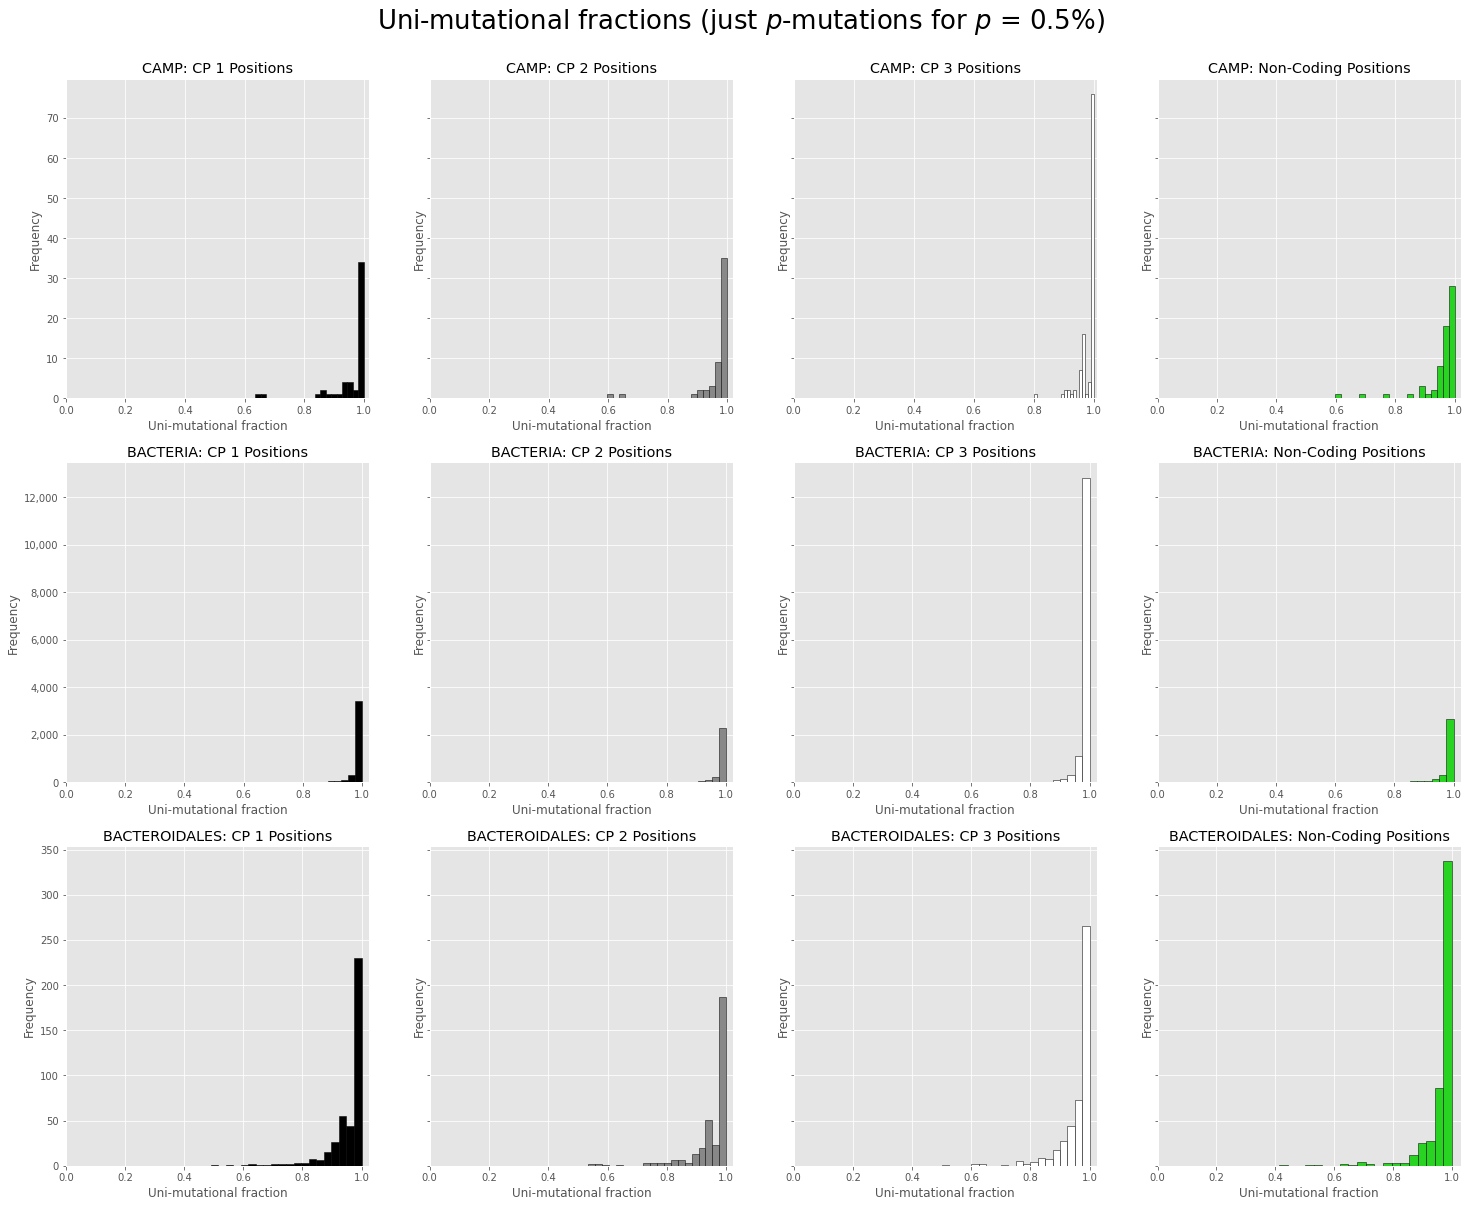

In [12]:
plot_unimut_frac_hists(0.005, figfilename="unimut-fractions-only-mutated-gt-0.5pct.png")

## Draw plots without filtering to $p$-mutations

So, all positions with valid uni-mutational fractions (i.e. all positions with at least one aligned mismatch) are included.

FYI, the reason the number of positions is the same for CP 1/2/3 for all seqs (even though we're technically counting positions in overlapping genes multiple times) is because we don't yet account for this, as mentioned in the paper. So -- each gene contributes N CP1 positions, N CP2 positions, and N CP3 positions -- because the gene length is divisible by 3. So when we add up a bunch of genes without accounting for overlap, we get the same number of positions across all codons.

CAMP: Number of p-mutations using p = None: defaultdict(<class 'int'>, {1: 397513, 2: 397513, 3: 397513, 'NC': 100806})
CAMP, CP 1: mean (valid) f-value = 0.9138679166050966, num valid f-values = 208,456
CAMP, CP 2: mean (valid) f-value = 0.9085152220188566, num valid f-values = 217,262
CAMP, CP 3: mean (valid) f-value = 0.9082265820783872, num valid f-values = 218,752
CAMP, CP 4: mean (valid) f-value = 0.9030255718899062, num valid f-values = 59,648
BACTERIA: Number of p-mutations using p = None: defaultdict(<class 'int'>, {1: 649213, 2: 649213, 3: 649213, 'NC': 207578})
BACTERIA, CP 1: mean (valid) f-value = 0.962866933175815, num valid f-values = 172,319
BACTERIA, CP 2: mean (valid) f-value = 0.9617277736537458, num valid f-values = 176,835
BACTERIA, CP 3: mean (valid) f-value = 0.9632942630220277, num valid f-values = 190,741
BACTERIA, CP 4: mean (valid) f-value = 0.9589200578775037, num valid f-values = 64,974
BACTEROIDALES: Number of p-mutations using p = None: defaultdict(<class

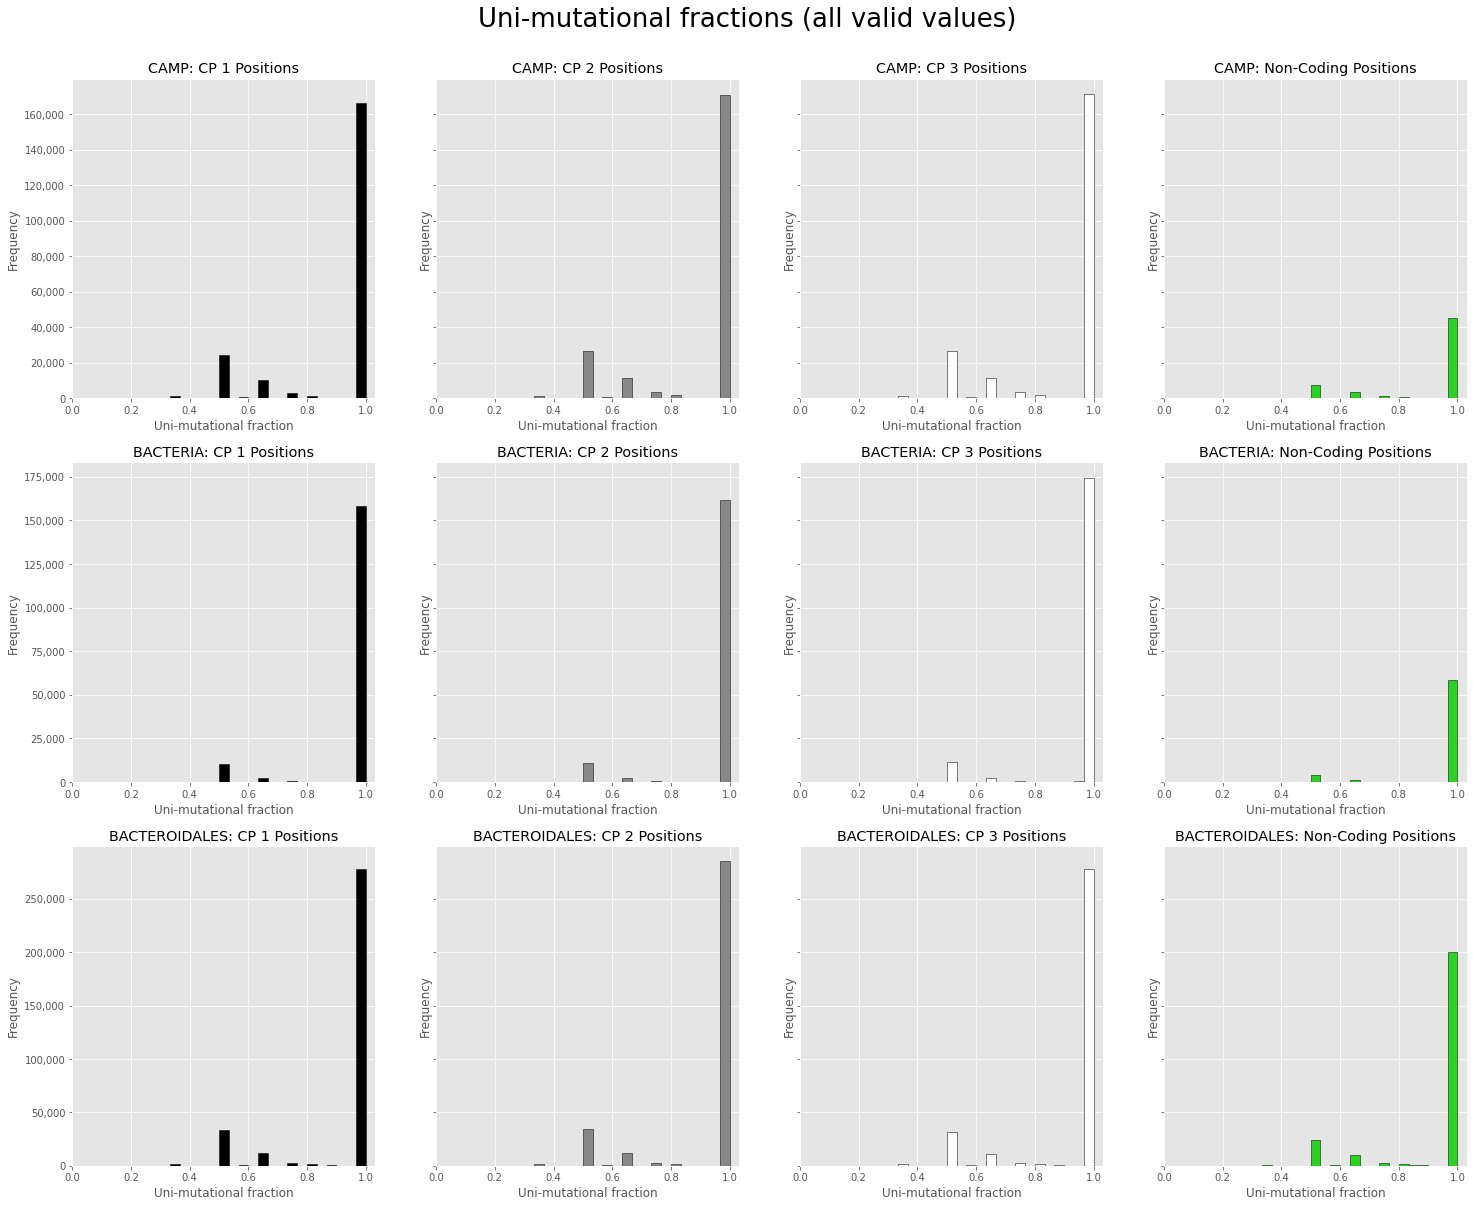

In [13]:
plot_unimut_frac_hists(figfilename="unimut-fractions-all.png")